In [ ]:
import datetime

# Data download methods

We will review three methods of downloading data:
1. Using Pandas `read_html`
2. Using a Pandas specific library
3. Using `requests` library to access generic APIs

### Pandas provides a way to access tables on web pages via `read_html`

Visit this page and use Pandas to extract the main table: https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)

In [ ]:
import pandas as pd

import requests
from io import StringIO

In [ ]:
URL = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)'
#tables = pd.read_html(URL)

# If the line above gives a 403 error

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r = requests.get(URL, headers=header)
tables = pd.read_html(StringIO(r.text))

In [ ]:
tables[2]

### Access economics related datasets via `pandas-datareader`
Many code examples in this section are from the documentation on https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [ ]:
#!pip install pandas-datareader

In [ ]:
import pandas_datareader.data as web

#### FRED (Federal Reserve Economic Data)
https://fred.stlouisfed.org/categories

Provides a large set of time series datasets: various interest rates, monetary rates, financial indicators, business surveys, etc.

In [ ]:
web.DataReader('GDP', 'fred', datetime.datetime(2023, 1, 1), datetime.datetime(2026, 1, 1))

Navigating the data sources is not very easy, although the website for FRED does provide the ability to search for datasets easily. If you are new to the website, try this:
1. Visit https://fred.stlouisfed.org/categories for a list of all data categories
2. Pick one or more series (example: Interest Rates -> Interest Rate Spreads -> 5/10-Year Breakeven Inflation Rate (https://fred.stlouisfed.org/series/T10YIE)
3. Find the series tag name next to the English name


<div>
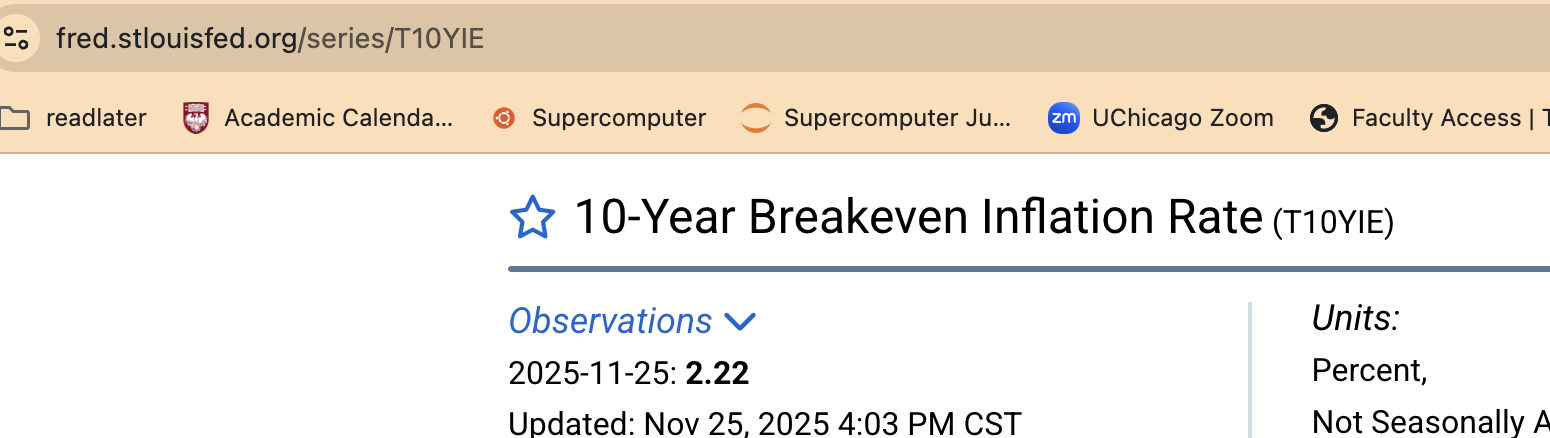
</div>


Notice T10YIE as the series name. Supply the 10 year and the 5 year series names together!

In [ ]:
web.DataReader(['T10YIE', 'T5YIE'], 'fred', datetime.datetime(2023, 1, 1), datetime.datetime(2024, 1, 1))

#### Fame/French data

Fama is U Chicago's own Noble prize winning professor and French is his long time collaborator. This dataset is likely to be of limited use to anyone outside the Fin Math department.

In [ ]:
from pandas_datareader.famafrench import get_available_datasets

In [ ]:
get_available_datasets()[:15]

In [ ]:
ds = web.DataReader('5_Industry_Portfolios', 'famafrench')
print(ds['DESCR'])

In [ ]:
ds[0].head()

#### World Bank data

In [ ]:
from pandas_datareader import wb

In [ ]:
matches = wb.search('gdp.*capita.*const')
matches

In [ ]:
wb_data = wb.download(indicator='NY.GDP.PCAP.KD', country=['US', 'CA', 'MX'], start=2005, end=2008)
wb_data

Many other data sources are avialable and described in the docs for pandas-datareader

### EDGAR data via `edgartools`

In [ ]:
#!pip install edgartools

In [ ]:
from edgar import Company, set_identity

In [ ]:
set_identity("YOUR_ID@uchicago.edu")

In [ ]:
Company("AAPL").get_financials().balance_sheet()

In [ ]:
Company("AAPL").get_filings(form="4")

### Accessing any API via requests (and API tokens)

In recent years, a standardized method has developed to request data from remote services via an "API" or "Application Programming Interface." This defines a standard and language/library agnostic way of requesting data (or services). Data providers will often provide "end-points," siimilar to normal web URLs.

Let's revisit the FRED website which provides lots of financial time series data. Earlier, we referenced the following URL: `https://fred.stlouisfed.org/series/T10YIE`. This URL refers to a web page that a human might visit to visually inspect data. FRED provides an API counterpart which can by used by a program to retrieve data in: `https://api.stlouisfed.org/fred/series?series_id=T10YIE&api_key=abcdefghijklmnopqrstuvwxyz123456`

Notice the `api_key=abcdefghijklmnopqrstuvwxyz123456` part; it refers to a method of authentication. We will return to this later

This API end-point is indeed just a normal URL. However, the data it returns is not a page designed for human consumption. It returns a data in a structured format.

Given a URL, you can use it various ways (not that an API key is required and will be discussed later):
1. Just paste it into the browser
2. Use a command line tool, such as `curl` to access it
3. Use a library which understands the http protocol (the same protocol used by your web browser to retrieve web pages). We will invesgitage this method further.

**Detour: API Keys**
If you use a web page, you might be asked to log in. How would you log in to a website which provides data? The whole point is that you are accessing the data programatically - what does it mean to "log in?"
API Keys are used to authenticate clients. You may have to manaully and interactively create an account on a website, create an API key and provide that API key everytime you make a programatic call. 

Here is an example of creating such a key for the FRED website

1. Create an account


<div>
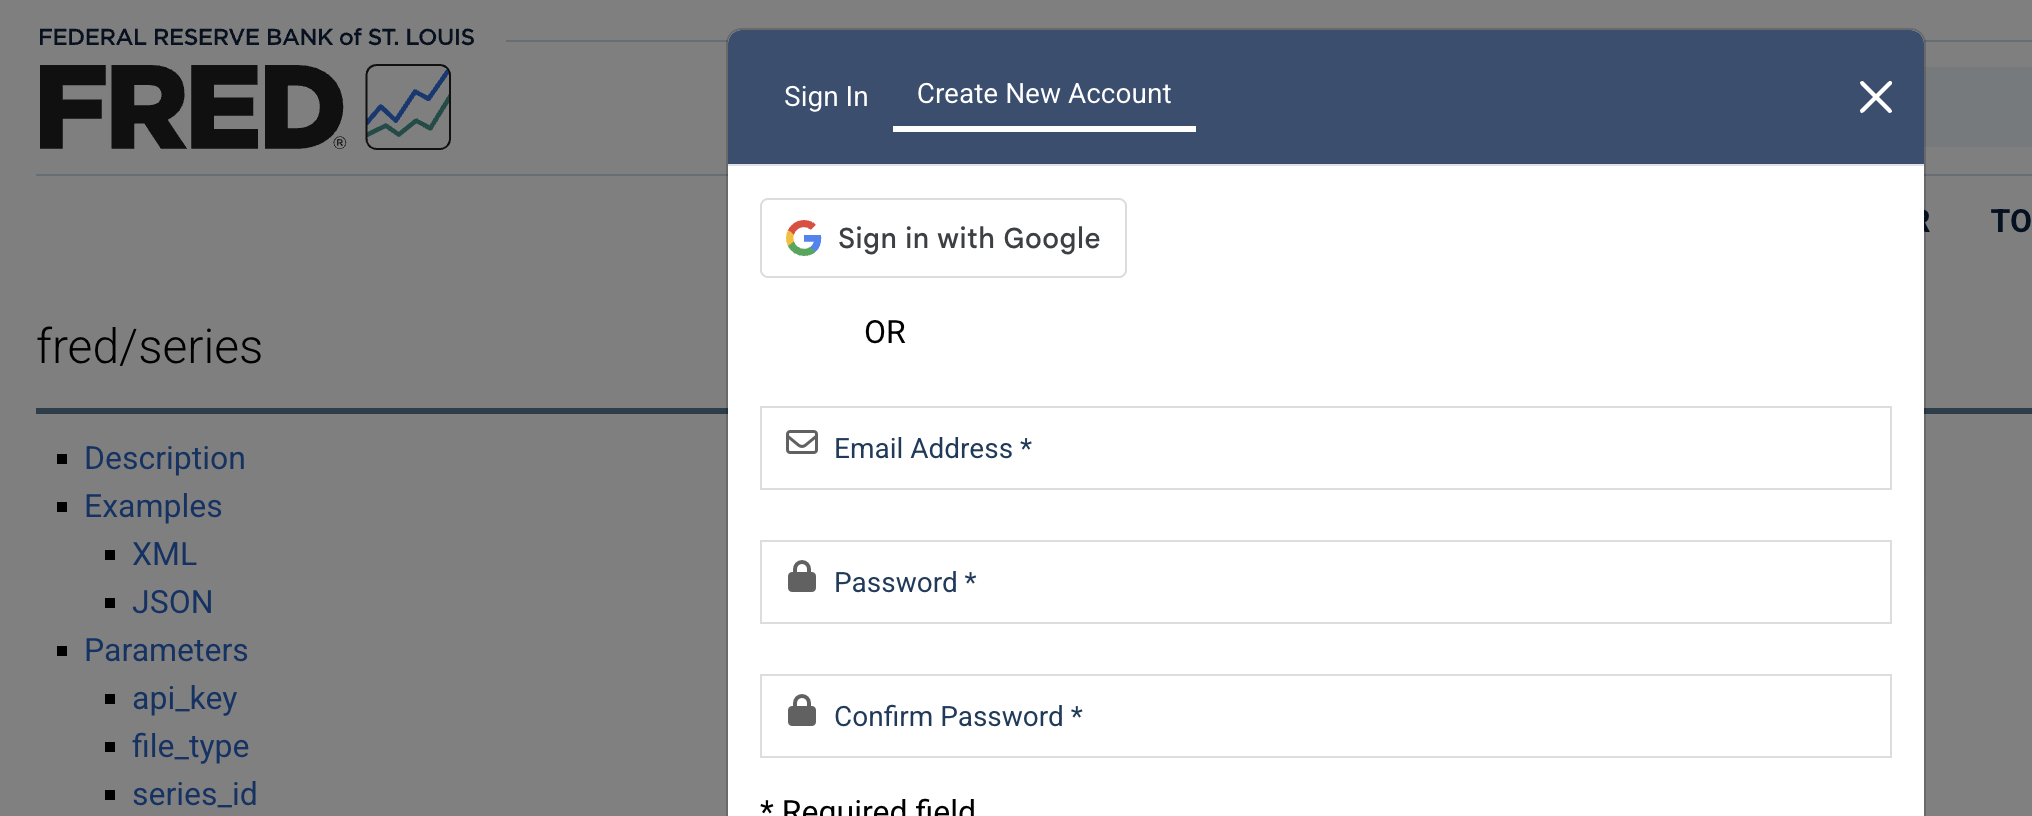
</div>


2. Create API keys

<div>
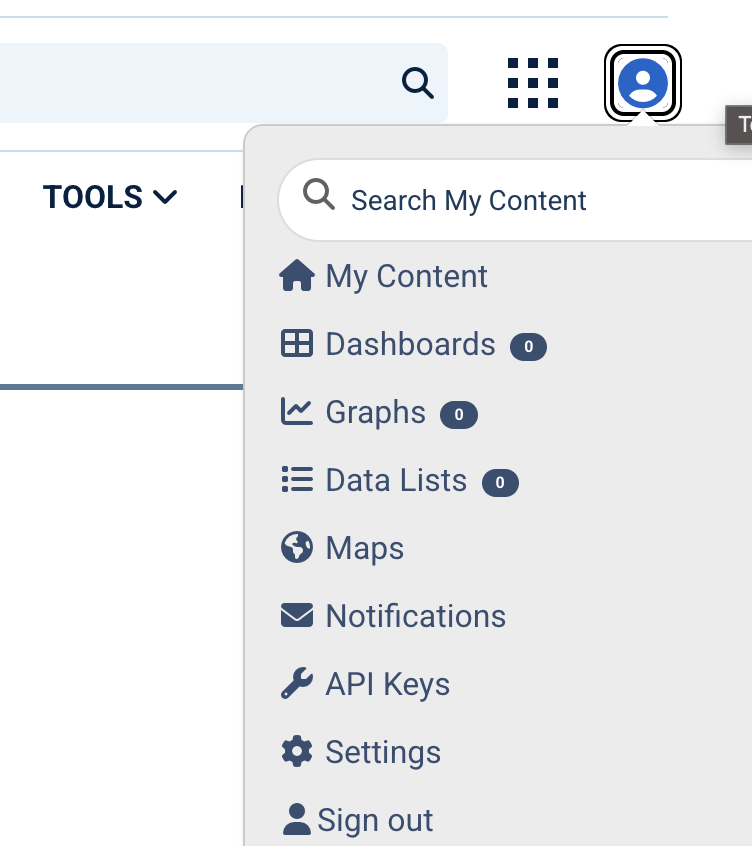
</div>


3. Continue creating an API key


<div>
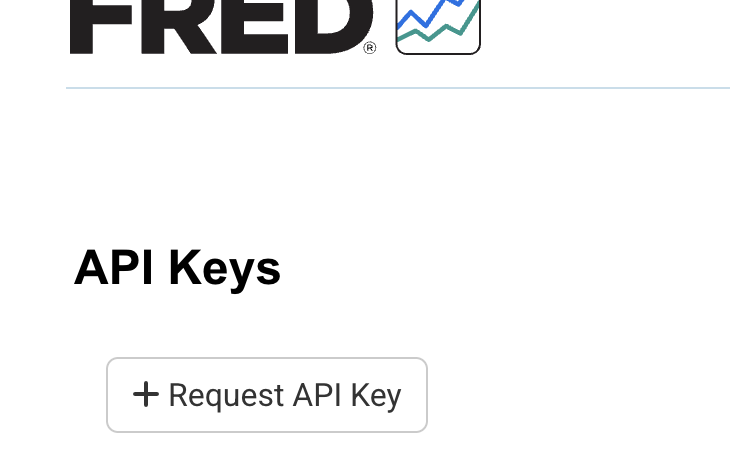
</div>


4. DO NOT SHARE THE API KEY WITH ANYONE!

<div>
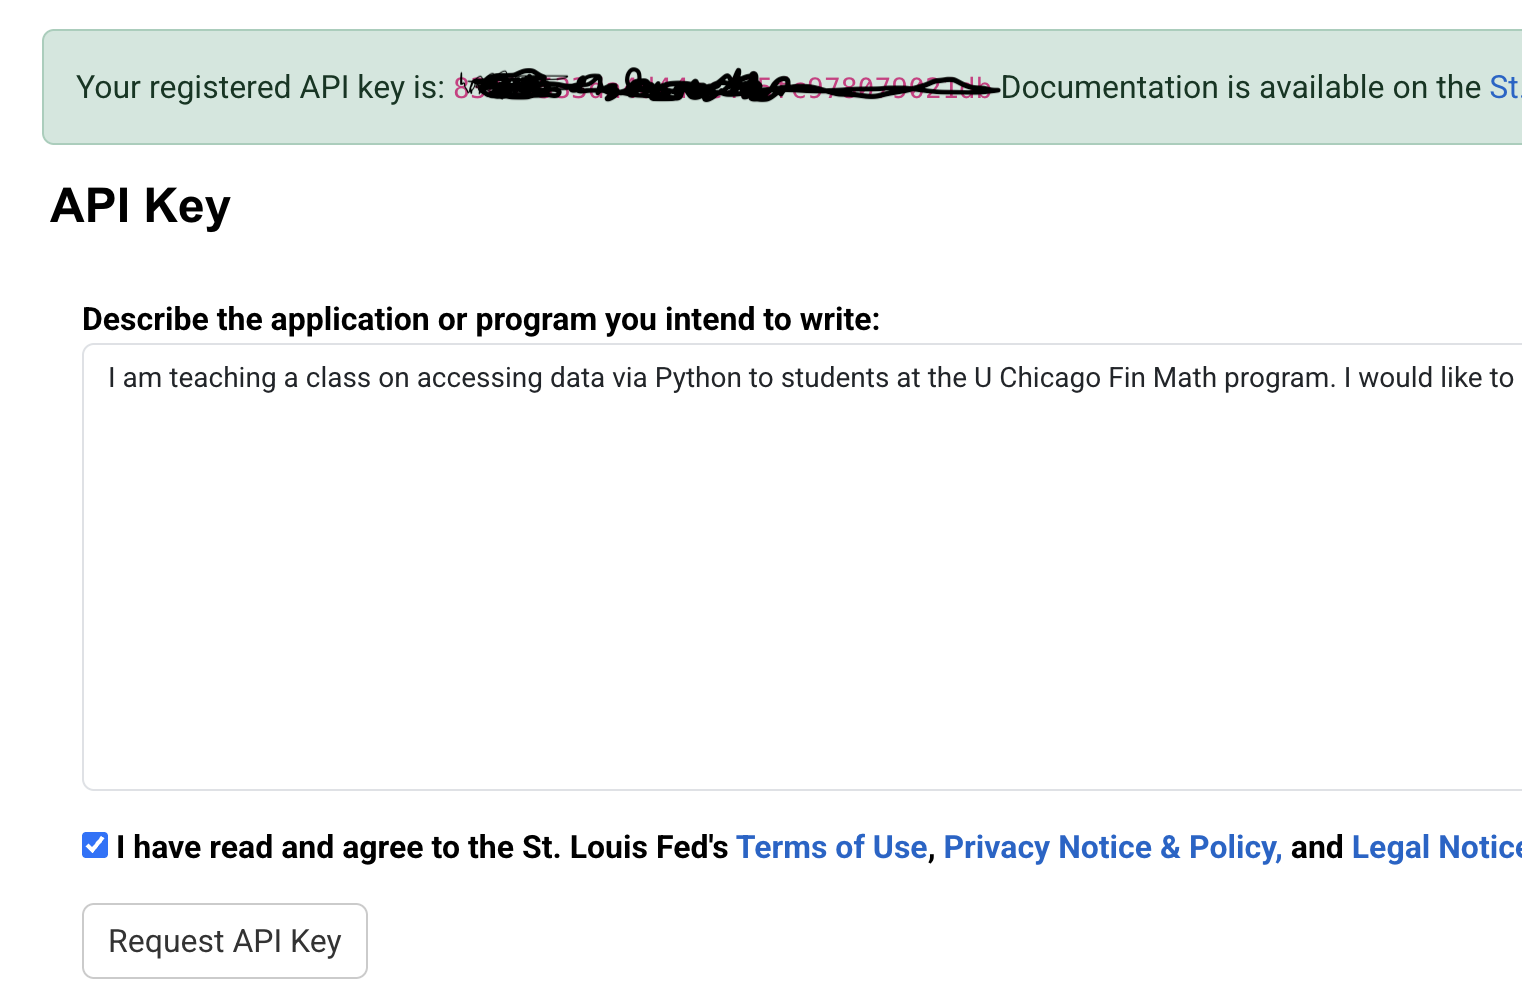
</div>


**KEY Security** If you share your key with anyone, they may abuse the system and you get the blame. The situation is far worse for commercial services, where a leaked key may cost of thousands of dollars (or more!). You should certainly not commit a key to version control. A common practice is to read the key from a file and to add that file to the .ignore file.

Create a file called `api_keys.txt` and format it as follows:

```json
{
"FRED":"12345myapikey67890"
}
```

In [ ]:
import json

with open('./api_keys.txt') as keys_file:
    keys = json.load(keys_file)

You should be able to access your key now via the code `keys['FRED']`, without exposing the key.

**API key detour ends**

Before the detour, we had come across the following end-point: `https://api.stlouisfed.org/fred/series?series_id=T10YIE&api_key=abcdefghijklmnopqrstuvwxyz123456`

The above URL can be broken up into two parts:
- URL: `https://api.stlouisfed.org/fred/series`
- Parameters: `?series_id=T10YIE&api_key=abcdefghijklmnopqrstuvwxyz123456`

Notice that the `?` character separates the URL and the parameter list. Further, each parameter is separated by the `&` character.

One of the best, yet generic, ways of accessing this end point is via the `requests` library

In [ ]:
#!pip install requests

In [ ]:
import requests

In [ ]:
api_url = 'https://api.stlouisfed.org/fred/series/observations'

params = {"file_type": "json", "series_id": "T10YIE", "api_key": keys['FRED']}

response = requests.get(api_url, params=params)

In [ ]:
response # 200 means the API call was successful ... 404 would have been bad

In [ ]:
downloaded_data = json.loads(response.text)
downloaded_data

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame(downloaded_data['observations'])